# Model Structure: Modified EffNetb0 with DistilBERT Captioning System(Both Transfer Learned).

# Import Dependencies

In [1]:
%%capture
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tqdm.notebook as tqdm
from sklearn.model_selection import train_test_split

import random
import copy
import cv2
import math

import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

!pip install livelossplot
import livelossplot

!pip install timm
import timm

!pip install transformers
import transformers

import nltk 
nltk.download('punkt')
import re
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load in the Dataset(FlicKR)

In [2]:
images_dataframe = pd.read_csv('../input/flickr8k/captions.txt')
images_dataframe = images_dataframe.drop_duplicates(subset = "image")
images_dataframe = images_dataframe.set_index("image")

Helpers for Reproducibility:

In [3]:
import os
import random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# Custom Dataloader

In [5]:
# HYPER PARAMETERS 
BASE_IMAGE_PATH = "../input/flickr8k/Images/"

TRAIN_SIZE = 0.9995
IMAGE_SIZE = 256

Transforms

In [6]:
# Transforms Used
TRAIN_TRANSFORMS = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.RandomGrayscale(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ColorJitter(),
  transforms.RandomRotation(15),
  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
TEST_TRANSFORMS = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [7]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
  def __init__(self, transforms, base_path, dataframe, device):
    self.dataframe = dataframe
    self.transforms = transforms 
    self.base_path = base_path
    self.device = device
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, idx):
    index = self.dataframe.index[idx]
    caption = str.strip(self.dataframe.iloc[idx]['caption'])
    caption = str.lower(caption)
    caption = re.sub(r'[^\w\s]','',caption)
    lower_caption = str.lower(caption)
    # Load in Image
    image_path = self.base_path + index
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.tensor(image, device = self.device).to(torch.float32) / 255.0
    image = image.transpose(1, 2).transpose(0, 1)
    image = self.transforms(image)
    
    return image, caption

In [8]:
Image_Dataset = ImageCaptioningDataset(TRAIN_TRANSFORMS, BASE_IMAGE_PATH, images_dataframe, device)

# Image Encoding

In [9]:
class ConvBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size, padding, groups):
    super().__init__()
    self.conv = nn.Conv2d(in_features, out_features, kernel_size = kernel_size, padding = padding, groups = groups)
    self.bn = nn.BatchNorm2d(out_features)
    self.act1 = nn.SiLU(inplace = True)
  def forward(self, x):
    return self.bn(self.act1(self.conv(x)))

In [10]:
class DownSampleConvBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size, padding, groups, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_features, out_features, kernel_size, stride, padding = padding, groups = groups)
    self.bn = nn.BatchNorm2d(out_features)
    self.act1 = nn.SiLU(inplace = True)
  def forward(self, x):
    return self.bn(self.act1(self.conv(x)))

In [11]:
class RegularSE(nn.Module):
  '''
  Regular Squeeze and Excitation Block 
  '''
  def __init__(self, in_dim, inner_dim):
    super().__init__()
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.Squeeze = nn.Linear(self.in_dim, self.inner_dim)
    self.SiLU = nn.SiLU(inplace = True)
    self.Excite = nn.Linear(self.inner_dim, self.in_dim)
  def forward(self, x):
    '''
    Performs Channel-Wise Attention using Squeeze Excite Blocks
    '''
    avg_pool = torch.mean(x, dim = -1)
    avg_pool = torch.mean(avg_pool, dim = -1) 
    squeeze = self.SiLU(self.Squeeze(avg_pool))
    excite = torch.sigmoid(self.Excite(squeeze)).unsqueeze(-1).unsqueeze(-1)
    return excite * x 


In [12]:
class ResBottleNeck(nn.Module):
  def __init__(self, in_features, inner_features, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.inner_features = inner_features
    
    self.squeeze = ConvBlock(self.in_features, self.inner_features, 1, 0, 1)
    self.process = ConvBlock(self.inner_features, self.inner_features, 3, 1, self.inner_features)
    self.SE = RegularSE(self.inner_features, self.inner_features // 4)
    self.expand = ConvBlock(self.inner_features, self.in_features, 1, 0, 1)
    self.gamma = nn.Parameter(torch.zeros(1, device = self.device))
  def forward(self, x):
    '''
    x: Tensor(B, C, H, W)
    '''
    squeeze = self.squeeze(x)
    process= self.process(squeeze)
    SE = self.SE(process)
    expand = self.expand(SE) 
    return expand * self.gamma + x


In [13]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, in_features, inner_features, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.inner_features = inner_features
    self.squeeze = ConvBlock(self.in_features, self.inner_features, 1, 0, 1)
    self.depthwise = ConvBlock(self.inner_features, self.inner_features, 3, 1, self.inner_features)
    self.SE = RegularSE(self.inner_features, self.in_features // 16)
    self.expand = ConvBlock(self.inner_features, self.in_features, 1, 0, 1)
    self.gamma = nn.Parameter(torch.zeros((1), device = self.device))
  def forward(self, x):
    squeeze = self.squeeze(x)
    depthwise = self.depthwise(squeeze)
    SE = self.SE(depthwise)
    expand = self.expand(SE)
    return expand * self.gamma + x

EfficientNetb0 Transfer Learned:

In [14]:
class EfficientNet(nn.Module):
  '''
  Modified EfficientNetb0
  '''
  def freeze(self, layer):
    for parameter in layer.parameters():
      parameter.requires_grad = False
  def unfreeze(self, layer):
    for parameter in layer.parameters():
      parameter.requires_grad = True
  def __init__(self, out_features, device):
    super().__init__()
    self.out_features = out_features
    self.device = device
    # Download Pretrained model and Weights
    self.model = timm.create_model("efficientnet_b3_pruned", pretrained = True)
    # Extract Layers
    self.conv1 = self.model.conv_stem
    self.bn1 = self.model.bn1
    self.act1 = self.model.act1
    # Pretrained Blocks
    self.block0 = self.model.blocks[0]
    self.block1 = self.model.blocks[1]
    self.block2 = self.model.blocks[2] # (B, 40, 32, 32)
    self.block3 = self.model.blocks[3]
    self.block4 = self.model.blocks[4] # (B, 120 16, 16)
    self.block5 = self.model.blocks[5]
    self.block6 = self.model.blocks[6] # (B, 384, 8, 8)
    # Freeze a Few Initial Layers
    self.freeze(self.block0)
    self.freeze(self.block1)
    self.freeze(self.bn1)
    self.freeze(self.conv1)
    self.freeze(self.block2)
    self.freeze(self.block3)
    self.freeze(self.block4)
    self.freeze(self.block5)
    self.freeze(self.block6)
    self.Attention3 = RegularSE(384, 64)

    self.features_extract =nn.Sequential(*
    [DownSampleConvBlock(384, 512, 5, 2, 1, 2), ConvBlock(512, 768, 1, 0, 1)] + 
    [InvertedResidualBlock(768, 1536, self.device) for i in range(10)])
    self.proj = ConvBlock(768, self.out_features, 1, 0, 1) 
  def forward(self, x):
    B, _, _, _ = x.shape
    conv1 = self.bn1(self.act1(self.conv1(x))) # (B, 32, 128, 128)
    
    block0 = self.block0(conv1)
    block1 = self.block1(block0)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    attention3 = self.Attention3(block6)
    
    extract_features = self.proj(self.features_extract(attention3)) # (B, 768, 4, 4)
    return extract_features.view(B, self.out_features, -1).transpose(1, 2) # (B, 16, 768)

# Custom Transformer(QANET)

In [15]:
class EncoderDecoderAttention(nn.Module):
  def __init__(self, in_features, inner_features, num_heads):
    super().__init__()
    self.in_features = in_features
    self.inner_features = inner_features
    self.num_heads = num_heads

    self.K = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.V = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Q = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Linear = nn.Linear(self.inner_features * self.num_heads, self.in_features)
  def forward(self, encoder, decoder):
    '''
    Encoder: Tensor(B, L_enc, C)
    Decoder: Tensor(B, L_dec, C)
    '''    
    B, L_enc, _ = encoder.shape
    B, L_dec, _ = decoder.shape 
    Keys = self.K(encoder)
    Values = self.V(encoder) # (B, L_enc, HI)
    Queries = self.Q(decoder) # (B, L_dec, HI)

    Keys = Keys.reshape(B, L_enc, self.num_heads, self.inner_features)
    Values = Values.reshape(B, L_enc, self.num_heads, self.inner_features) 
    Queries = Queries.reshape(B, L_dec, self.num_heads, self.inner_features)

    Keys = Keys.transpose(1, 2)
    Values = Values.transpose(1, 2)
    Queries = Queries.transpose(1, 2)

    Keys = Keys.reshape(B * self.num_heads, L_enc, self.inner_features)
    Values = Values.reshape(B * self.num_heads, L_enc, self.inner_features)
    Queries = Queries.reshape(B * self.num_heads, L_dec, self.inner_features)

    att_mat = F.softmax(torch.bmm(Keys, Queries.transpose(1, 2)) / math.sqrt(self.inner_features)) # (B, L_enc, L_dec)
    att_scores = torch.bmm(Values.transpose(1, 2), att_mat) # (B, L_dec, I)
    att_scores = att_scores.reshape(B, self.num_heads, L_dec, self.inner_features)
    att_scores = att_scores.transpose(1, 2)
    att_scores = att_scores.reshape(B, L_dec, -1)
    return self.Linear(att_scores)

In [16]:
class MultiHeadAttention(nn.Module):
  '''
  Computes MultiHeadAttention
  '''
  def __init__(self, in_features, inner_features, num_heads):
    super().__init__()
    self.in_features = in_features
    self.inner_features = inner_features
    self.num_heads = num_heads
    
    self.K = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.V = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Q = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Linear = nn.Linear(self.inner_features * self.num_heads, self.in_features)
  def forward(self, x):
    '''
    x: Tensor(B, L, C)
    '''
    B, L, _ = x.shape
    Keys = self.K(x) # (B, L, HI)
    Values = self.V(x)
    Queries = self.Q(x) # (B, L, HI)

    Keys = Keys.reshape(B, L, self.num_heads, self.inner_features)
    Values = Values.reshape(B, L, self.num_heads, self.inner_features)
    Queries = Queries.reshape(B, L, self.num_heads, self.inner_features)

    Keys = Keys.transpose(1, 2) 
    Values = Values.transpose(1, 2)
    Queries = Queries.transpose(1, 2)

    Keys = Keys.reshape(B * self.num_heads, L, self.inner_features)
    Values = Values.reshape(B * self.num_heads, L, self.inner_features)
    Queries = Queries.reshape(B * self.num_heads, L, self.inner_features)

    att_mat = F.softmax(torch.bmm(Keys, Values.transpose(1, 2)) / math.sqrt(self.inner_features))
    att_scores = torch.bmm(att_mat, Queries) # (BH, L, I)

    att_scores = att_scores.reshape(B, self.num_heads, L, self.inner_features)
    att_scores = att_scores.transpose(1, 2)
    att_scores = att_scores.reshape(B, L, -1)
    return self.Linear(att_scores)

In [17]:
class FFN(nn.Module):
    def __init__(self, in_dim, drop_prob = 0.1):
        super().__init__()
        self.drop_prob = drop_prob
        self.in_dim = in_dim
        self.Linear1 = nn.Linear(self.in_dim, self.in_dim)
        self.act1 = nn.GELU()
        self.Drop = nn.Dropout(self.drop_prob)
        self.Linear2 = nn.Linear(self.in_dim, self.in_dim)
    def forward(self, x):
        return self.Linear2(self.Drop(self.act1(self.Linear1(x))))

In [18]:
class QAEncoder(nn.Module):
  '''
  One QA Net Encoder Module
  '''
  def __init__(self, in_dim, inner_dim, num_heads, device):
    super().__init__()
    self.device = device
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.num_heads = num_heads

    self.MAH = MultiHeadAttention(self.in_dim, self.inner_dim, self.num_heads)

    self.Linear = FFN(self.in_dim)
  def layer_norm(self, val):
    return F.layer_norm(val, (val.shape[1], val.shape[2]))
  def forward(self, x):
    '''
    x: Tensor(B, L, C)
    '''
    attended = self.layer_norm(self.MAH(x) + x)
    linear = self.layer_norm(self.Linear(attended) + attended)
    return linear

Model Blocks

In [19]:
class Tokenizer(nn.Module):
  def __init__(self, model_name, max_length):
    super().__init__()
    self.model_name = model_name
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
    self.num_words = self.tokenizer.vocab_size
    self.START = self.tokenizer.cls_token
    self.END = self.tokenizer.sep_token
    self.START_ID = self.tokenizer.cls_token_id
    self.END_ID = self.tokenizer.sep_token_id 
    self.max_length = max_length
  def forward(self, x):
    '''
    Tokenizes sentences using HuggingFace 
    '''
    tokenized_sentences = self.tokenizer(x, add_special_tokens = True, padding = 'max_length', truncation = True, max_length = self.max_length, return_tensors = 'pt')
    return tokenized_sentences

In [20]:
class QANet(nn.Module):
  def freeze(self, layer):
    for parameter in layer.parameters():
        parameter.requires_grad = False
  def __init__(self, in_dim, max_length, device):
    super().__init__()
    # Tokenizer 
    self.in_dim = in_dim
    self.max_length = max_length
    self.model_name = 'distilbert-base-uncased'
    
    self.tokenizer = Tokenizer(self.model_name, self.max_length)
    self.embeddings = transformers.AutoModel.from_pretrained(self.model_name)
    self.freeze(self.embeddings)
    
    self.num_classes = self.tokenizer.tokenizer.vocab_size
    self.device = device
    # HYPER PARAMETERS
    self.num_att_heads = 16
    self.num_decoder = 1
    # Embeddings
    # Decoder
    self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(self.in_dim, self.num_att_heads, dropout = 0, activation ='gelu'), self.num_decoder)
    # Dense Decoder
    self.linear = nn.Linear(self.in_dim, self.num_classes)
    self.criterion = nn.CrossEntropyLoss()
  def forward_train(self, x, GT):
    '''
    x: Tensor(B, L, C), the encoded image features
    GT: List of Sentences
    Returns Loss
    '''
    tokenized_GT = self.tokenizer(GT) # (B, L)
    GT_input_ids = tokenized_GT['input_ids'].to(self.device)
    GT_attention_ids = tokenized_GT['attention_mask'].to(self.device)
    B, L = GT_input_ids.shape
    encoded_image = x
    
    total_loss = torch.zeros((1), device = self.device)
    for i in range(1, L):
      input_IDs = copy.deepcopy(GT_input_ids[:, :i])
      attention_mask = copy.deepcopy(GT_attention_ids[:, :i])
      encodings = self.embeddings(input_IDs, attention_mask = attention_mask)[0]
        
      encodings = self.decoder(encodings.transpose(0,1), encoded_image.transpose(0, 1)).transpose(0, 1)
      # Average Logits
      logits = torch.mean(encodings, dim = 1) # (B, 768)
      predicted = self.linear(logits) # (B, C)
      GT_id = GT_input_ids[:, i] # GT Targets: (B)
      bools = GT_id != self.tokenizer.tokenizer.pad_token_id
      GT_id = GT_id[bools]
      predicted = predicted[bools, :]
    
      L = GT_id.shape[0]
      if L == 0:
        break
      loss = self.criterion(predicted, GT_id)
      total_loss = total_loss + loss
    return total_loss

  def forward(self, x):
    '''
    x: Tensor(B, L, C), the encoded image features
    '''
    B, L, C = x.shape
    max_length = self.max_length
    # Encode Image Features 
    encoded_images = x
    # Create Starter Tokens 
    sentences = [self.tokenizer.START for i in range(B)]
    sentences_idx = [[self.tokenizer.START_ID] for i in range(B)]
    # Finished Array
    finished = [False for i in range(B)]
    for i in range(max_length):
      input_ids = torch.tensor(copy.deepcopy(sentences_idx), device = self.device)
      attention_mask = torch.ones((B, i + 1), device = self.device)
      encoded = self.embeddings(input_ids, attention_mask = attention_mask)[0]
      # Decode using QADecoders
      encoded = self.decoder(encoded.transpose(0, 1), encoded_images.transpose(0, 1)).transpose(0, 1)
      # Average the Logits
      logits = torch.mean(encoded, dim = 1) # (B, C)
      # Linear Layers
      scores = F.softmax(self.linear(logits), dim = -1) # (B, C)
      # Argmax over scores
      _, indices = torch.max(scores, dim = -1) # (B) 
      for b in range(B):
        if finished[b]:
          sentences_idx[b] += [0] # Garbage Value, it wont be added or used anyways.Pads tensor
          continue # Already Completed Sentences
        if indices[b].item() == self.tokenizer.END_ID:
          # Sentence Terminated
          finished[b] = True
          sentences[b] += f" {self.tokenizer.tokenizer.decode(indices[b].item())}"
          sentences_idx[b] += [indices[b].item()]
        else:
          sentences[b] +=f" {self.tokenizer.tokenizer.decode(indices[b].item())}"
          sentences_idx[b] += [indices[b].item()]
    return sentences

In [21]:
class FullModel(nn.Module):
  '''
  Houses the Full Image Captioning Model
  '''
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.in_dim = 768
    self.max_length = 20
    self.image_encoder = EfficientNet(self.in_dim, self.device)
    self.QANet = QANet(self.in_dim, self.max_length, self.device)
  def forward_train(self, images, captioning):
    image_encoded = self.image_encoder(images)
    return self.QANet.forward_train(image_encoded, list(captioning))
  def forward(self, images):
    image_encoded = self.image_encoder(images)
    return self.QANet(image_encoded)

# Custom Training Loop:

In [22]:
class ImageCaptioningSolver(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.model = FullModel(self.device)
    self.optim = optim.Adam(self.model.parameters(), lr= 1e-3, weight_decay = 1e-3)
    self.decay = optim.lr_scheduler.StepLR(self.optim, 1, 0.95)
  def forward(self, x):
    self.eval()
    with torch.no_grad():
      return self.model(x)
  def evaluate(self, valloader):
    '''
    Evaluates the Model's BLEU score.
    '''
    self.eval()
    with torch.no_grad():
      total_bleu = 0
      count = 0
      for images, labels in tqdm.tqdm(valloader):
        predicted = self.model(images)
        bleu = nltk.translate.bleu_score.corpus_bleu(labels, predicted)
        total_bleu += bleu
        count += 1
        del images
        del labels
        del predicted
        torch.cuda.empty_cache()
    return total_bleu / count
  def training_loop(self, trainloader, valloader, NUM_EPOCHS, display_every = 64):
    liveloss = livelossplot.PlotLosses()
    best_val_bleu  = 0
    best_val_loss = 999
    torch.cuda.empty_cache()
    for EPOCH in range(NUM_EPOCHS):
      self.train()
      logs = {}
      total_loss = 0
      count = 0
      for images, labels in trainloader:
        self.optim.zero_grad()
        loss = self.model.forward_train(images, labels)
        loss.backward()
        self.optim.step()
        print(f"Step: {count}, loss: {loss.item()}")
        total_loss += loss.item()
        count += 1
        del images
        del labels
        torch.cuda.empty_cache()
        if count == display_every:
          break
      logs['loss'] = total_loss / count
      self.decay.step()
      print(f"EPOCH: {EPOCH}, total_loss: {logs['loss']}")
      
      self.eval()
      sample_caption = ""
      with torch.no_grad():
        logs['val_loss'] = 0
        logs['accuracy'] = 0
        count = 0
    
        for images, labels in trainloader:
          loss = self.model.forward_train(images, labels)
          pred_sentences = self.model(images)
            
          sample_caption = pred_sentences[0]
          # Compute BLEU between GT and Predicted sentences
          bleu = nltk.translate.bleu_score.corpus_bleu(labels, pred_sentences)
          logs['val_loss'] += loss.item()
          logs['accuracy'] += bleu
          count += 1
          del images
          del labels
          torch.cuda.empty_cache()
          break
        logs['val_loss'] /= count
        logs['accuracy'] /= count
      
      liveloss.update(logs)
      liveloss.send()
      
      if logs['val_loss'] < best_val_loss:
        best_val_loss = logs['val_loss']
        torch.save(self.model.state_dict(), "./BestVal.pth")
      if logs['accuracy'] > best_val_bleu:
        best_val_bleu = logs['accuracy']
        torch.save(self.model.state_dict(), "./BestAcc.pth")
      
      print(f"E:{EPOCH}VL{round(logs['val_loss'], 3)}VA{round(logs['accuracy'], 3)}loss:{round(logs['loss'], 3)}, Sample Caption Created: {sample_caption}")

In [23]:
%%capture
solver = ImageCaptioningSolver(device)
solver.to(device)

In [24]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
train_dataset, val_dataset = torch.utils.data.random_split(Image_Dataset, [len(Image_Dataset) - TEST_BATCH_SIZE, TEST_BATCH_SIZE], generator = torch.Generator().manual_seed(42))

In [25]:
TrainDataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, worker_init_fn = seed_worker)
ValDataloader = torch.utils.data.DataLoader(val_dataset, batch_size = TEST_BATCH_SIZE)

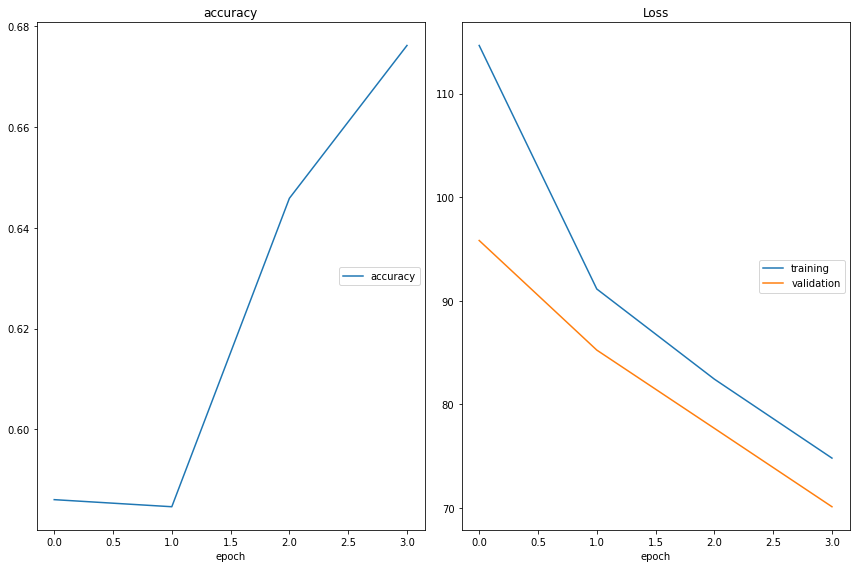

accuracy
	accuracy         	 (min:    0.585, max:    0.676, cur:    0.676)
Loss
	training         	 (min:   74.810, max:  114.652, cur:   74.810)
	validation       	 (min:   70.116, max:   95.821, cur:   70.116)
E:3VL70.116VA0.676loss:74.81, Sample Caption Created: [CLS] a man in a blue shirt and a [SEP]
Step: 0, loss: 71.89313507080078
Step: 1, loss: 66.26532745361328
Step: 2, loss: 67.41143035888672
Step: 3, loss: 69.8499755859375
Step: 4, loss: 69.5391616821289


In [ ]:
solver.training_loop(TrainDataloader, ValDataloader, 100, display_every = 16)

In [ ]:
torch.save(solver.state_dict(), "./FinalModel.pth")